<a href="https://colab.research.google.com/github/13693763686/data-analysis/blob/master/scikit-learn%20notebooks/SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#支持向量机

In [ ]:
#支持向量机和集成学习的boosting是机器学习中非常强大的算法
#它向我们展示了频率派的优化理论，展示了典型的拉格朗日方法
#同时它向我们展示了非线性变化和逆变换来解决非线性问题的模板
#它引入核方法来减少计算复杂性的思路也很棒，原和对偶的计算复杂度的考虑也十分重要
#这一节就对支持向量机进行学习，重点放在可视化，核函数和不均衡数据集的评估上面

##支持向量的可视化与核函数

In [60]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.datasets import make_circles,make_blobs,make_classification,make_moons
from sklearn import svm
%matplotlib inline

In [66]:
n_samples = 100
datasets = [
    make_moons(n_samples=n_samples, noise=0.1, random_state=0),
    make_circles(n_samples=n_samples, noise=0.1, factor=0.5, random_state=1),
    make_blobs(n_samples=n_samples, centers=2, random_state=5),#分簇的数据集
    make_classification(n_samples=n_samples,n_features = 2,n_informative=2,n_redundant=0, random_state=5)
                #n_features：特征数，n_informative：带信息的特征数，n_redundant：不带信息的特征数
      ]

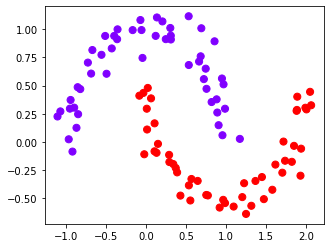

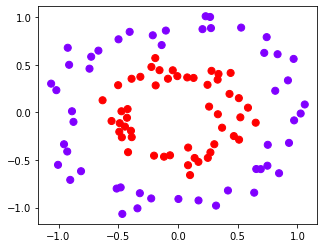

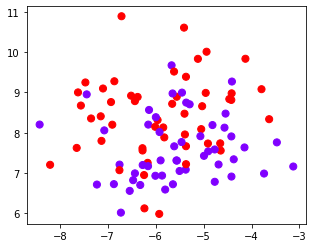

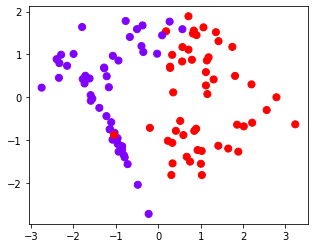

In [67]:
Kernel = ["linear","poly","rbf","sigmoid"]
 
#四个数据集分别是什么样子呢？
#为了可视化的方便，四组数据都是二维的，可以直接在图中表示
for X,Y in datasets:
    plt.figure(figsize=(5,4))
    plt.scatter(X[:,0],X[:,1],c=Y,s=50,cmap="rainbow")

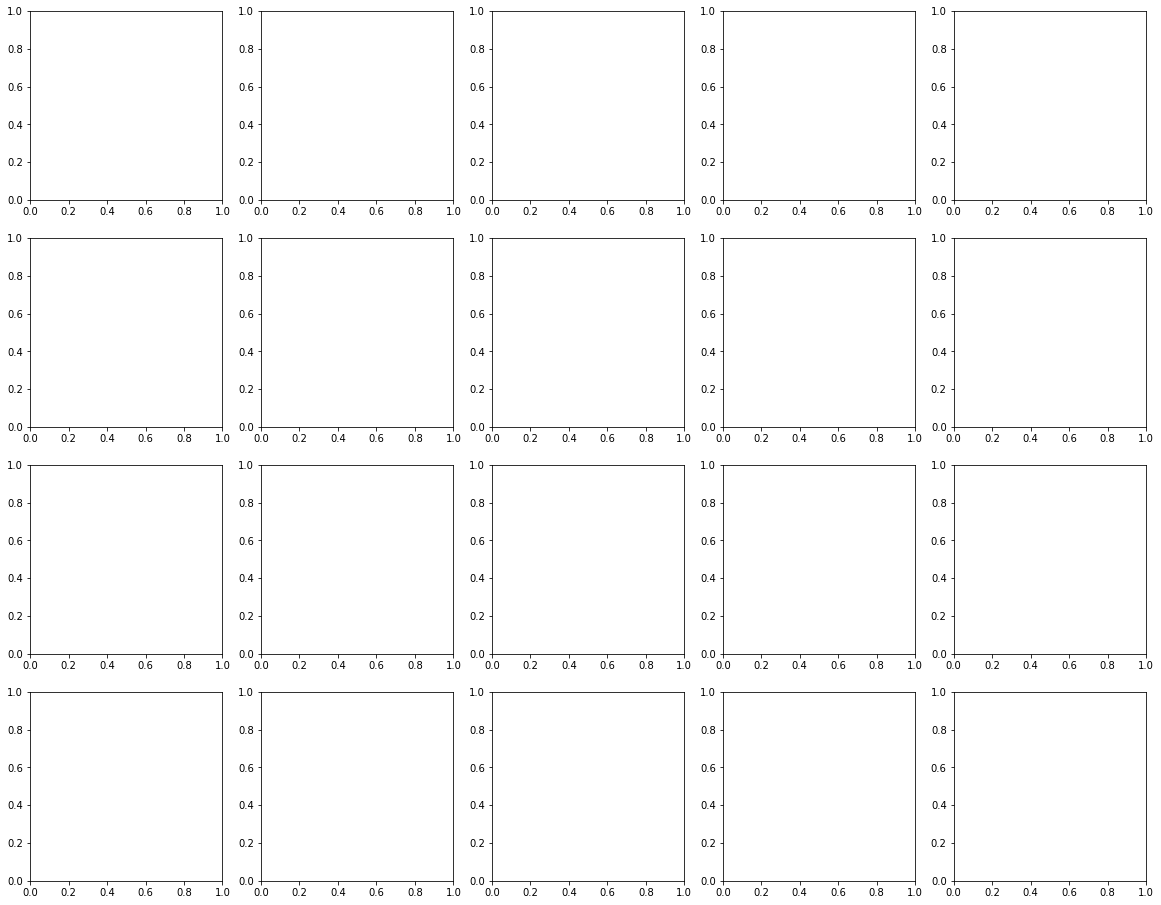

In [68]:
#准备陈列图像的画布，每一列作为一个核的展示，因此有kernel加一个原始的数据集
#每一行作为一个数据集的分类
nrows=len(datasets)
ncols=len(Kernel) + 1
 
fig, axes = plt.subplots(nrows, ncols,figsize=(20,16))

In [75]:
#进行函数的的作图
#enumerate按序号展开内容,datasets的每一项拆箱即可得到特征矩阵和标签矩阵
for ds_cnt, (X,Y) in enumerate(datasets):
    
    #在图像中的第一列，放置原数据的分布
    #ds_cnt指的是行数，因此，遍历所有的datasets即做出图像
    ax = axes[ds_cnt, 0]
    if ds_cnt == 0:
        ax.set_title("Input data")
    ax.scatter(X[:, 0], X[:, 1], c=Y, zorder=10, cmap=plt.cm.Paired,edgecolors='k')
    ax.set_xticks(())
    ax.set_yticks(())
    
    #第二层循环：在不同的核函数中循环
    #从图像的第二列开始，一个个填充分类结果
    for est_idx, kernel in enumerate(Kernel):
        
        #定义子图位置
        ax = axes[ds_cnt, est_idx + 1]
        
        #建模
        clf = svm.SVC(kernel=kernel, gamma=2).fit(X, Y)
        score = clf.score(X, Y)
        
        #绘制图像本身分布的散点图
        #zorder指定覆盖顺序
        ax.scatter(X[:, 0], X[:, 1], c=Y
                   ,zorder=10
                   ,cmap=plt.cm.Paired,edgecolors='k')
        #绘制支持向量
        #根据SVM内置的属性将支持向量的特征给透明化
        ax.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=50,
                    facecolors='none', zorder=10, edgecolors='k')# facecolors='none':透明的
        
        #绘制决策边界，利用contour函数，为此需要构造一个网格
        #处于作图的美观性，将标签的最大最小值调到比数据的最大值和最小值大一点的程度
        x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
        y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
        
        #np.mgrid，合并了我们之前使用的np.linspace和np.meshgrid的用法
        #np.meshgrid根据两个列表，把所有的需要的坐标点都定义了出来，下面需要处理即可，利用np.vstack([xx.ravel(),yy.ravel()]).T即可
        #一次性使用最大值和最小值来生成网格
        #表示为[起始值：结束值：步长]
        #如果步长是复数，则其整数部分就是起始值和结束值之间创建的点的数量，并且结束值被包含在内
        XX, YY = np.mgrid[x_min:x_max:200j, y_min:y_max:200j]
        #np.c_，类似于np.vstack和转置的综合功能
        #reshape操作，注意根据文档要求，要报此Z和xx的形状相同
        Z = clf.decision_function(np.c_[XX.ravel(), YY.ravel()]).reshape(XX.shape)
        #填充等高线不同区域的颜色
        #注意pcolormesh的使用，颜色的选取也很有特色
        ax.pcolormesh(XX, YY, Z > 0, cmap=plt.cm.Paired)
        #绘制等高线
        ax.contour(XX, YY, Z, colors=['k', 'k', 'k'], linestyles=['--', '-', '--'],
                    levels=[-1, 0, 1])
        
        #设定坐标轴为不显示
        ax.set_xticks(())
        ax.set_yticks(())
        
        #将标题放在第一行的顶上
        if ds_cnt == 0:
            ax.set_title(kernel)
            
        #为每张图添加分类的分数   
        ax.text(0.95, 0.06, ('%.2f' % score).lstrip('0')
                , size=15
                , bbox=dict(boxstyle='round', alpha=0.8, facecolor='white')
                    #为分数添加一个白色的格子作为底色
                , transform=ax.transAxes #确定文字所对应的坐标轴，就是ax子图的坐标轴本身，这个事相对位置，上面的小数为占比而不是具体数值
                , horizontalalignment='right' #位于坐标轴的什么方向
               )
 
plt.tight_layout()
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: UserWarning: No contour levels were found within the data range.


<Figure size 432x288 with 0 Axes>

In [70]:
#由以上的图像可以观察出在不同的特征数据下，不同核的效果是不同的
#对应线性核来说，它只能分类线性的数据,在其它数据上面表现不太好
#对应sigmoid核来说，基本上表现很差，因此，不应该考虑它
#观察rbf和多项式核，显然rfb的能力很强，但要时刻注意过拟合的问题

##ROC曲线在衡量分类问题中的应用

In [76]:
#在分类问题中，标签不均衡是比较常见的问题，因为大多数的分类问题属于异常检测的问题
#在这种问题的设定之下，精确率的衡量完全不足以反映算法的能力，因为对于极度不平衡的数据，完全偏向一方的数据也能得到非常好的结果
#因此，在异常检测的分类检验中，我们必须要考察出两种标签的预测能力

###混淆矩阵

In [78]:
#在异常检测中，通常异常类为1，非异常类为0
#以表格的形式将实际标签和预测标签的值列成表格的形式就是混淆矩阵
#混淆矩阵有一些衡量指标
#accuracy精确率，一般的衡量方法
#precision指预测为异常的所有样本中实际为异常的比例，又叫查准率，对应搜索引擎的结果
#recall指所有的异常值中有多少个被识别出来
#由于召回率和精确率为此消彼长的关系，它们之间不能同时达到最优，因此综合考虑，即F-score，计算方法为倒数之和除二
#假负率，false negative rate即对应的异常的样本被我们判断为正常的比率，这个衡量我们对异常值的捕捉能力
#特异度和假正率与recall和假负率对应
#假正率即假装正确的概率，即实际为错误的样本中，我们预测了多少为异常的
#sklearn中提供了对应的处理函数

In [80]:
#ROC曲线的目标是衡量模型在尽可能地捕捉少数类的同时也能不要误伤多数类
#ROC全称为The Receiver Operating Characteristics Curve
#recall表示捕捉少数类的能力，而FPR代表了不做少数类带来的代价，因此我们的想法就是
#当recall为纵坐标时，FPR为横坐标时，recall的增加会带来很小的FPR的增加，即图像很逗，对应面积的话，就是面积为1
#注意每一次训练只能得到一组值，那么同一个参数如何得到多组概率
#我们的方法是利用threshold，对应可以输出概率的算法，我们可以认为的规定为1的概率的阈值，这样就可以分别调整
#对于逻辑回归，很直接，对于SVM由于我们可以以间隔归一化作为概率的指代，也可以利用里面的概率实现

In [81]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.datasets import make_blobs

In [82]:
class_1 = 500 #类别1有500个样本
class_2 = 50 #类别2只有50个
centers = [[0.0, 0.0], [2.0, 2.0]] #设定两个类别的中心
clusters_std = [1.5, 0.5] #设定两个类别的方差，通常来说，样本量比较大的类别会更加松散
X, y = make_blobs(n_samples=[class_1, class_2],
                  centers=centers,
                  cluster_std=clusters_std,
                  random_state=0, shuffle=False)

In [84]:
clf_proba = svm.SVC(kernel="linear",C=1.0,probability=True).fit(X,y)

In [85]:
prob = clf_proba.predict_proba(X)

In [86]:
#对于这个接口来讲的话，我们发现它会把概率都返回，包括等于1和不等于1的部分
prob[:5]

array([[0.68701655, 0.31298345],
       [0.2930518 , 0.7069482 ],
       [0.95464749, 0.04535251],
       [0.97172238, 0.02827762],
       [0.99191968, 0.00808032]])

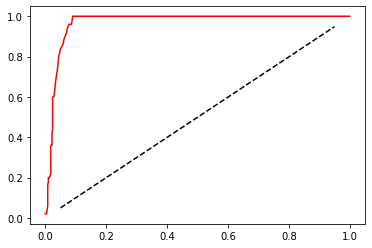

In [87]:
#开始绘图
#由上面可以发现返回的是两列，且按0/1的顺序进行排列，因此提取出第一列
probrange = np.linspace(clf_proba.predict_proba(X)[:,1].min(),clf_proba.predict_proba(X)[:,1].max(),num=50,endpoint=False)

from sklearn.metrics import confusion_matrix as CM, recall_score as R
import matplotlib.pyplot as plot

recall = []
FPR = []

for i in probrange:
    y_predict = []
    for j in range(X.shape[0]):
        if clf_proba.predict_proba(X)[j,1] > i:
            y_predict.append(1)
        else:
            y_predict.append(0)
    #注意指定异常的标签的值，并且注意实际标签和预测标签的位置
    cm = CM(y,y_predict,labels=[1,0])
    recall.append(cm[0,0]/cm[0,:].sum())
    FPR.append(cm[1,0]/cm[1,:].sum())
#这里的sort可以加也可以不加，由于两者由理论上保证一定是同向增加的，因此sort之后的对应关系仍然存在
#recall.sort()
#FPR.sort()

plt.plot(FPR,recall,c="red")
plt.plot(probrange+0.05,probrange+0.05,c="black",linestyle="--")
plt.show()

In [90]:
#下面的话我们来看sklearn中的关于AUC的函数
from sklearn.metrics import roc_auc_score as AUC
from sklearn.metrics import roc_curve

In [93]:
FPR, recall, thresholds = roc_curve(y,clf_proba.decision_function(X),pos_label=1)

In [94]:
FPR

array([0.   , 0.   , 0.006, 0.006, 0.008, 0.008, 0.01 , 0.01 , 0.014,
       0.014, 0.018, 0.018, 0.022, 0.022, 0.024, 0.024, 0.028, 0.028,
       0.03 , 0.03 , 0.032, 0.032, 0.036, 0.036, 0.04 , 0.04 , 0.042,
       0.042, 0.044, 0.044, 0.05 , 0.05 , 0.054, 0.054, 0.058, 0.058,
       0.066, 0.066, 0.072, 0.072, 0.074, 0.074, 0.086, 0.086, 1.   ])

In [96]:
area = AUC(y,clf_proba.decision_function(X))

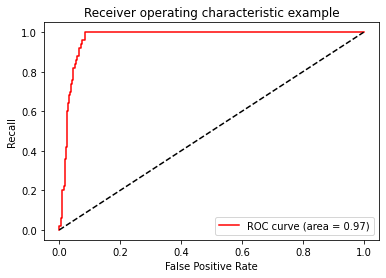

In [97]:
plt.figure()
plt.plot(FPR, recall, color='red',
         label='ROC curve (area = %0.2f)' % area)
plt.plot([0, 1], [0, 1], color='black',linestyle='--')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('Recall')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [98]:
#由上面图像可以看出，借助距离这样的置信度也可以达到比较好的效果，因此我们可以考虑每次使用置信度即可，而不需要考虑所谓的概率
#由于我们的目的是得到尽可能高的recall的同时，保证FPR比较小
#因此，我们定义最优化的结果为recall和FPR的差值最大
#由于上述的操作过程，我们可以看到FPR和Recall的值已经存好，因此
max((recall - FPR).tolist())

0.914

In [100]:
maxindex = (recall - FPR).tolist().index(max(recall - FPR))

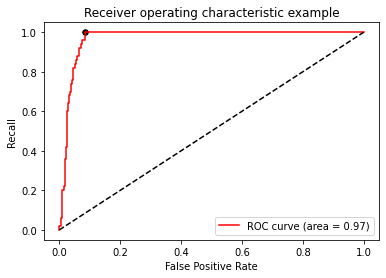

In [101]:
#根据上述的含义，其实这个点就是垂直距离最大的点，将点画到图中进行验证
plt.figure()
plt.plot(FPR, recall, color='red',
         label='ROC curve (area = %0.2f)' % area)
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.scatter(FPR[maxindex],recall[maxindex],c="black",s=30)
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('Recall')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [103]:
clf_proba.dual_coef_.shape

(1, 83)

In [104]:
clf_proba.support_vectors_.shape

(83, 2)

In [105]:
#在对偶的软间隔SVM上，其对偶的系数不再具有稀疏性，很多点都会成为支持向量，而不再是硬间隔下的两个边界上的点
#注意SV的种类和C的关系
#对于那些没有violation的点，可能分类正确，此时一定不是支持向量
#但是如果恰好位于边界上，那么可能是支持向量也可能不是
#对于存在violation的点，那么系数一定为C，不为0，是支持向量